# Prédiction de séries temporelles avec des RNN


Data: Dataset "Bike Sharing in Washington D.C. "


Resultat:  %80 de précision (métrique : 1-mae/mean)


In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler



# Data processing

Chargement du dataset

In [2]:

dataset = pd.read_csv('C:/Code_ML/Code/NoteBooks Cours TS - RNN-LSTM/notebook RNN/day.csv')

dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


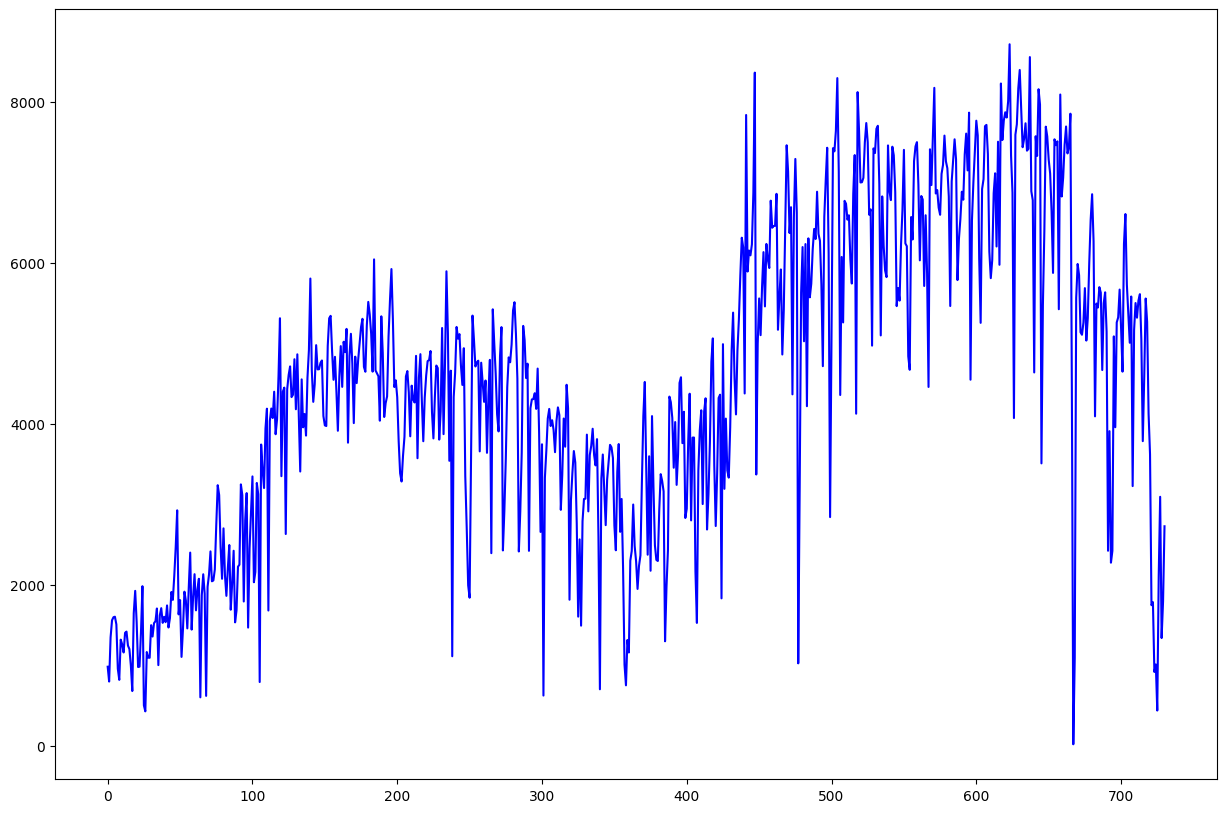

In [3]:
plt.figure(figsize=(15,10))
plt.plot(dataset['cnt'], color='blue')
plt.show()

## One Hot Encoding



In [4]:
one_hot = pd.get_dummies(dataset['weekday'], prefix='weekday')
dataset = dataset.join(one_hot)

one_hot = pd.get_dummies(dataset['weathersit'], prefix='weathersit')
dataset = dataset.join(one_hot)

one_hot = pd.get_dummies(dataset['mnth'], prefix='mnth')
dataset = dataset.join(one_hot)

# Scaling

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(array(dataset['cnt']).reshape(len(dataset['cnt']), 1))
series = pd.DataFrame(scaled)
series.columns = ['cntscl']

In [6]:
dataset = pd.merge(dataset, series, left_index=True, right_index=True)

dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,cntscl
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,False,False,False,False,False,False,False,False,False,0.110792
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,False,False,False,False,False,False,False,False,False,0.089623
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,False,False,False,False,False,False,False,False,False,0.152669
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,False,False,False,False,False,False,False,False,False,0.177174
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,False,False,False,False,False,False,False,False,False,0.181546


### Data splitting

In [7]:
number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(dataset) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(dataset), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 731 631 50 50


In [8]:


datatrain = dataset[:number_of_training_data]
datatest = dataset[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = dataset[-number_of_holdout_data:]



# Préparation de données 3D pour le modèle séquentiel

In [9]:
in_seq1 = array(datatrain['holiday'])
in_seq2 = array(datatrain['workingday'])
in_seq3 = array(datatrain['temp'])
in_seq4 = array(datatrain['atemp'])
in_seq5 = array(datatrain['hum'])
in_seq6 = array(datatrain['windspeed'])
in_seq7 = array(datatrain['weekday_0'])
in_seq8 = array(datatrain['weekday_1'])
in_seq9 = array(datatrain['weekday_2'])
in_seq10 = array(datatrain['weekday_3'])
in_seq11 = array(datatrain['weekday_4'])
in_seq12 = array(datatrain['weekday_5'])
in_seq13 = array(datatrain['weekday_6'])
in_seq14 = array(datatrain['weathersit_1'])
in_seq15 = array(datatrain['weathersit_2'])
in_seq16 = array(datatrain['weathersit_3'])
out_seq_train = array(datatrain['cntscl'])

In [10]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [11]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_train))

In [12]:


in_seq1 = array(datatest['holiday'])
in_seq2 = array(datatest['workingday'])
in_seq3 = array(datatest['temp'])
in_seq4 = array(datatest['atemp'])
in_seq5 = array(datatest['hum'])
in_seq6 = array(datatest['windspeed'])
in_seq7 = array(datatest['weekday_0'])
in_seq8 = array(datatest['weekday_1'])
in_seq9 = array(datatest['weekday_2'])
in_seq10 = array(datatest['weekday_3'])
in_seq11 = array(datatest['weekday_4'])
in_seq12 = array(datatest['weekday_5'])
in_seq13 = array(datatest['weekday_6'])
in_seq14 = array(datatest['weathersit_1'])
in_seq15 = array(datatest['weathersit_2'])
in_seq16 = array(datatest['weathersit_3'])
out_seq_test = array(datatest['cntscl'])



In [13]:


in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))




In [14]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_test))

In [15]:


in_seq1 = array(datahold['holiday'])
in_seq2 = array(datahold['workingday'])
in_seq3 = array(datahold['temp'])
in_seq4 = array(datahold['atemp'])
in_seq5 = array(datahold['hum'])
in_seq6 = array(datahold['windspeed'])
in_seq7 = array(datahold['weekday_0'])
in_seq8 = array(datahold['weekday_1'])
in_seq9 = array(datahold['weekday_2'])
in_seq10 = array(datahold['weekday_3'])
in_seq11 = array(datahold['weekday_4'])
in_seq12 = array(datahold['weekday_5'])
in_seq13 = array(datahold['weekday_6'])
in_seq14 = array(datahold['weathersit_1'])
in_seq15 = array(datahold['weathersit_2'])
in_seq16 = array(datahold['weathersit_3'])
out_seq_hold = array(datahold['cntscl'])



In [16]:


in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))



In [17]:


datahold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_hold))



In [18]:


n_features = datatrain_feed.shape[1]
n_input = 10
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=len(datatrain_feed))



In [19]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [20]:
generator_hold = TimeseriesGenerator(datahold_feed, out_seq_hold, length=n_input, batch_size=1)

### Modélisation et entrainement

In [21]:


print("timesteps, features:", n_input, n_features)



timesteps, features: 10 17


In [22]:
model = Sequential()

model.add(SimpleRNN(4, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(1, activation='relu'))

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mse')

C:\Users\twentz\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4)                 88        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


In [24]:
score = model.fit_generator(generator_train, epochs=3000, verbose=0, validation_data=generator_test)

C:\Users\twentz\AppData\Local\Temp\ipykernel_24136\1338044232.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  score = model.fit_generator(generator_train, epochs=3000, verbose=0, validation_data=generator_test)


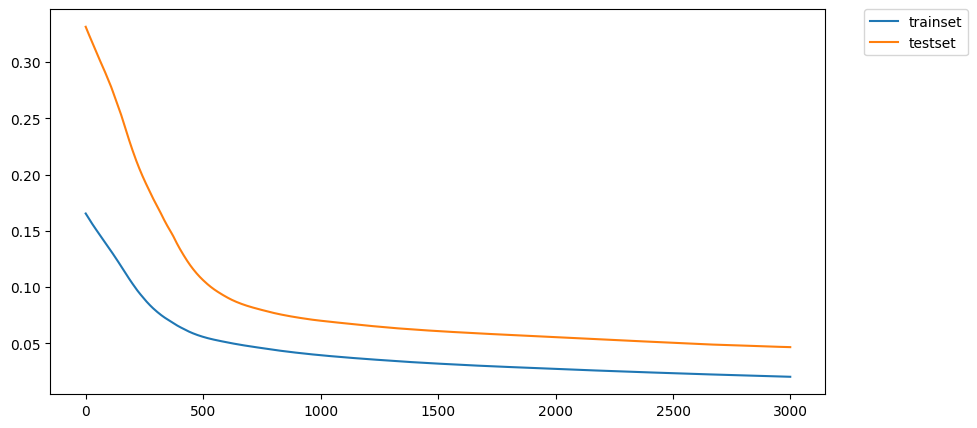

In [25]:


losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



# Prédictions sur les données de test

In [27]:


df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    #df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)
    df_result = pd.concat([df_result, pd.DataFrame([{'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}])], ignore_index=True)
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']


1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 12m

In [28]:
df_result

,Actual,Prediction,Diff
0,7572.0,5074.559082,-32.982579
1,7328.0,4979.410645,-32.049527
2,8156.0,4952.090820,-39.282849
3,7965.0,6346.429688,-20.321033
4,3510.0,5994.384277,70.780179
5,5478.0,4403.952148,-19.606569
6,6392.0,3658.598877,-42.762846
7,7691.0,4744.680176,-38.308670
8,7570.0,5949.911621,-21.401432
9,7282.0,6116.813477,-16.000914


### Calcul de la précision de prédiction

In [29]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  6254.425
mae: 1564.0785301208496
mae/mean ratio:  25.007551135729496 %
correctness:  74.9924488642705 %


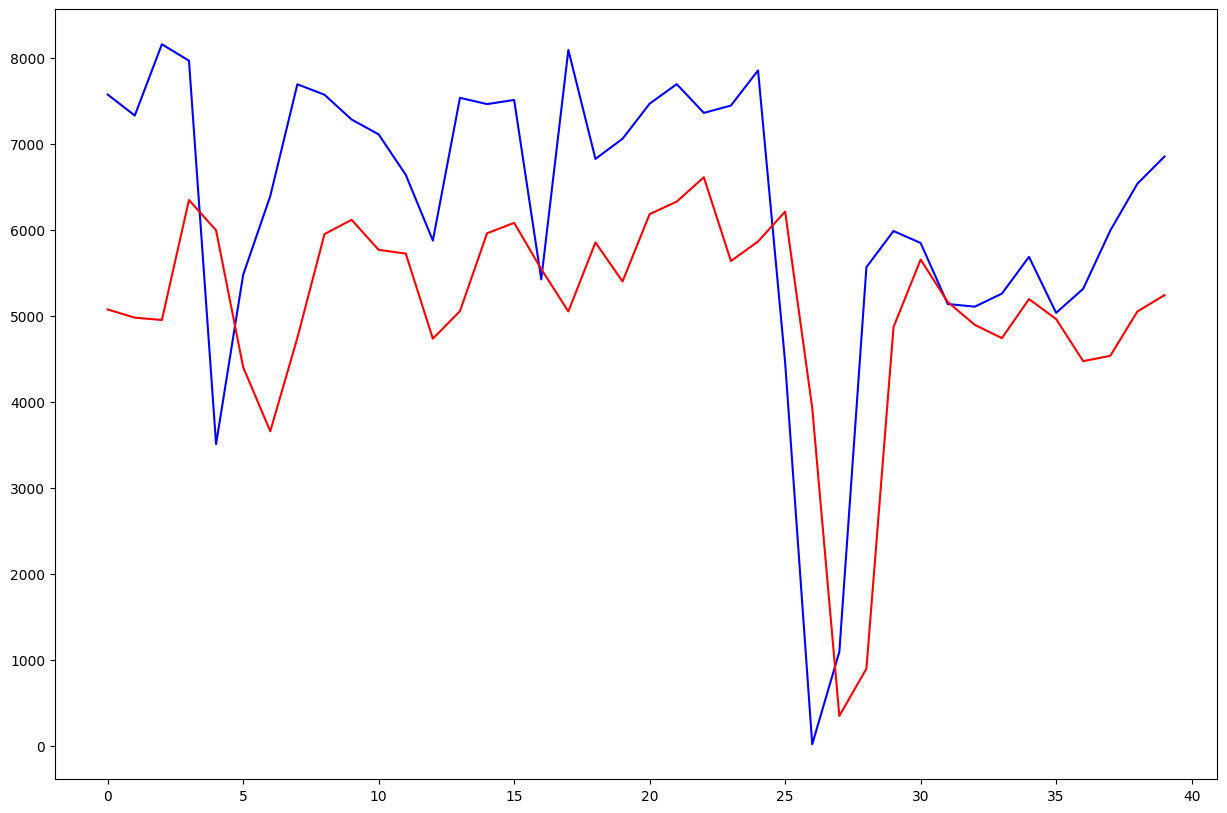

In [30]:


plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()



## Prédiction pour les data exterieures au modèle

In [31]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    #df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)
    df_result = pd.concat([df_result, pd.DataFrame([{'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}])], ignore_index=True)
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 0s/epoch - 0s/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 0s/epoch - 0s/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 6ms/epoch - 6ms

In [32]:
df_result

,Actual,Prediction,Diff
0,2425.0,5330.867676,119.829595
1,3910.0,2814.655762,-28.013919
2,2277.0,3401.615967,49.390249
3,2424.0,3632.525391,49.856658
4,5087.0,4381.238770,-13.873820
5,3959.0,5625.692871,42.098835
6,5260.0,4332.838379,-17.626647
7,5323.0,4906.712402,-7.820545
8,5668.0,4938.327148,-12.873551
9,5191.0,4882.215820,-5.948453


In [33]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")


mean:  4001.15
mae: 1008.5054656982422
mae/mean ratio:  25.20539009280437 %
correctness:  74.79460990719562 %


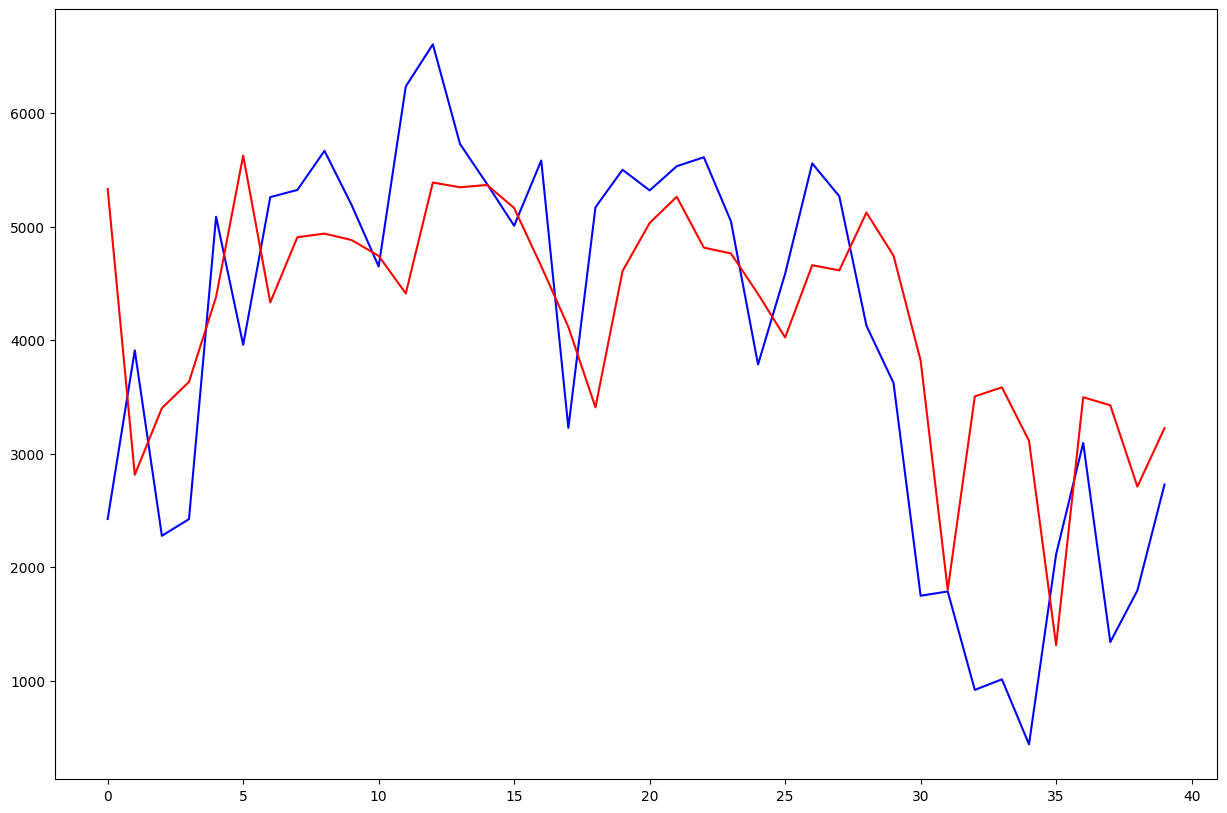

In [34]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()
